In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q pillow==4.1.1

In [0]:
### Install Pytorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x58fca000 @  0x7fc24c5d62a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
### Import packages
import json
import torch
import PIL
import copy
import time
import numpy as np
import seaborn as sns
from collections import OrderedDict
from torch import nn, optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import datasets, transforms, models
from google.colab import files
from PIL import Image

In [0]:
!pip install -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
data_dir = "/content/drive/My Drive/AI/flower_data"
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# Define your transforms for the training, validation, and testing sets
# Using random rotation, random resize and random flips (horizontal and vertical)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    #transforms.Resize(255),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Just resize and crop
val_test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=val_test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
batch = 32
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch, shuffle=False)

images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [0]:
### Load label mapping file


cat_to_name = drive.CreateFile({'id' : '1zCjC-qnt9eoL6_U_cwgx-E-y869_rAPd'})
cat_to_name.GetContentFile('cat_to_name.json')
cat_to_name = json.load(open('cat_to_name.json'))
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [0]:
model = models.resnet152(pretrained=True) # densenet121
# Turning off gradiants features
for param in model.parameters():
    param.requires_grad = False
model.fc # model.classifier

Linear(in_features=2048, out_features=1000, bias=True)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
   
'''
model.classifier = nn.Sequential(OrderedDict([
                                ('fc1', nn.Linear(1024, 1000)),
                                ('relu1', nn.ReLU()),
                                ('dropout1', nn.Dropout(p=0.5)),
                                ('fc2', nn.Linear(1000, 512)),
                                ('relu2', nn.ReLU()),
                                ('dropout2', nn.Dropout(p=0.5)),
                                ('fc3', nn.Linear(512, 102))
                                ])) 
'''

model.fc = nn.Sequential(OrderedDict([
                                ('fc1', nn.Linear(2048, 1024)),
                                ('relu1', nn.ReLU()),
                                ('dropout1', nn.Dropout(p=0.5)),
                                ('fc2', nn.Linear(1024, 512)),
                                ('relu2', nn.ReLU()),
                                ('dropout1', nn.Dropout(p=0.7)),
                                ('fc3', nn.Linear(512, 102))
                                ]))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(),lr=0.01, momentum=0.7, weight_decay=0.0001)  # lr=0.01, momentum=0.9, weight_decay=0.0005
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # step_size=8, gamma=0.5

model.to(device)
print(device)

cuda


In [0]:
steps = 0
epochs = 200
valid_loss_min = np.Inf

print("Length of training data: ", len(trainloader))

#######################
#### Training loop ####
#######################

for epoch in range(epochs):
  
    scheduler.step()
    train_loss = 0
  
    model.train()
    train_losses = []
    counter = 0
    for inputs, labels in trainloader:
      
        counter+=1
        print("Training Batch: ", counter)
        
        inputs, labels = inputs.to(device), labels.to(device) 
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
           
        loss = criterion(logps, labels)
    
        loss.backward()
                
        optimizer.step() 
 
        train_loss += loss.item()
      
    
    #########################
    #### Validation loop ####
    #########################
    
    model.eval()
    accuracy = 0
    valid_loss = 0
    valid_losses = []
    step = 0
    
    for inputs, labels in validloader:
      
        step += 1
        print("Validation Batch: ", step)
      
        inputs, labels = inputs.to(device), labels.to(device)
    
        output = model.forward(inputs)
    
        loss = criterion(output, labels)
    
        valid_loss += loss.item()
    
        ps = torch.exp(output)
        top_ps, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
       
    print("Epoch {}/{}.. ".format(epoch+1, epochs),
          "Training loss: {:.3f}.. ".format(train_loss / len(trainloader)),  
          "Validation loss: {:.3f}..".format(valid_loss / len(validloader)),
          "Validation accuracy: {:.3f}..".format(accuracy / len(validloader)))
    
    if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss / len(validloader)))
          torch.save(model.state_dict(), 'drive/My Drive/AI/flower_model.pt')
          valid_loss_min = valid_loss
          
    model.train()

Length of training data:  206
Training Batch:  1
Training Batch:  2
Training Batch:  3
Training Batch:  4
Training Batch:  5
Training Batch:  6
Training Batch:  7
Training Batch:  8
Training Batch:  9
Training Batch:  10
Training Batch:  11
Training Batch:  12
Training Batch:  13
Training Batch:  14
Training Batch:  15
Training Batch:  16
Training Batch:  17
Training Batch:  18
Training Batch:  19
Training Batch:  20
Training Batch:  21
Training Batch:  22
Training Batch:  23
Training Batch:  24
Training Batch:  25
Training Batch:  26
Training Batch:  27
Training Batch:  28
Training Batch:  29
Training Batch:  30
Training Batch:  31
Training Batch:  32
Training Batch:  33
Training Batch:  34
Training Batch:  35
Training Batch:  36
Training Batch:  37
Training Batch:  38
Training Batch:  39
Training Batch:  40
Training Batch:  41
Training Batch:  42
Training Batch:  43
Training Batch:  44
Training Batch:  45
Training Batch:  46
Training Batch:  47
Training Batch:  48
Training Batch:  49

In [0]:
model.load_state_dict(torch.load('drive/My Drive/AI/flower_model.pt'))

In [0]:
model.epochs = epochs
model.accuracy = accuracy
model.train_loss = train_loss
model.valid_loss = valid_loss
model.cat_to_name = cat_to_name
model.class_to_idx = training_dataset.class_to_idx

model.scheduler = scheduler
model.optimizer = optimizer
model.criterion = criterion

checkpoint_path = "/content/drive/My Drive/AI/Saved Checkpoint/checkpoint.pt"

model.to(device)
                  
checkpoint = {'model': model,
              'epochs': model.epochs,            
              'accuracy': model.accuracy,
              'train_loss': model.train_loss,
              'valid_loss': model.valid_loss,
              'cat_to_name': model.cat_to_name,
              'state_dict': model.state_dict(),            
              'scheduler': model.scheduler.state_dict(),
              'optimizer': model.optimizer.state_dict(),
              'criterion': model.criterion.state_dict(),                                              
              'class_to_idx': model.class_to_idx}
     
torch.save(checkpoint, checkpoint_path)

NameError: ignored

In [0]:
### Load the checkpoint and rebuild the model
def load_checkpoint(checkpoint_path):
    
    checkpoint = torch.load(checkpoint_path)  
    
    model = checkpoint['model']
    model.epochs = checkpoint['epochs']
    model.accuracy = checkpoint['accuracy']
    model.train_loss = checkpoint['train_loss']
    model.valid_loss = checkpoint['valid_loss']    
    model.cat_to_name = checkpoint['cat_to_name']  
    model.load_state_dict(checkpoint['state_dict'])
    
    model.scheduler.load_state_dict(checkpoint['scheduler'])
    model.optimizer.load_state_dict(checkpoint['optimizer'])                       
    model.criterion.load_state_dict(checkpoint['criterion'])  
    
    model.class_to_idx = checkpoint['class_to_idx']    
    
    model.eval() 
    
    return model

In [0]:
model = load_checkpoint(checkpoint_path)
print("Model:\n", model, '\n')
print("Model State Dict:\n", model.state_dict().keys(), '\n')

In [0]:
image_path = train_dir + '/45/image_07123.jpg'

In [0]:
### Image processing 
def process_image(image_path):
    
    ### Open image
    image = Image.open(image_path)
    
    image_transforms = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224), 
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485,0.456,0.406],
                                                                [0.229,0.224,0.225])])  
    
    image = image_transforms(image)
    image = np.array(image)
        
    print(image.shape, '\n') 
    
    return image

In [0]:
image = process_image(image_path)

(3, 224, 224) 



In [0]:
### Display the image
def imshow(image, ax=None, title=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ### PyTorch tensors assume the color channel is the first dimension
    ### but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    ### Set the title 
    flower_name = cat_to_name['1']
    plt.title(flower_name)
    
    ### Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    ### Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.grid(False) 
        
    return ax

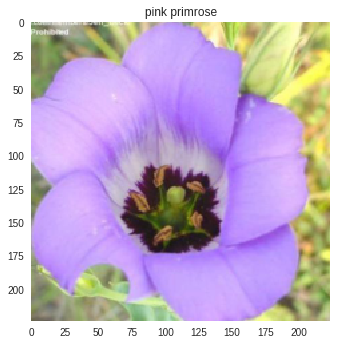

In [0]:
### Call 'imshow()' 
imshow(image, ax=None, title=None)

In [0]:
### Define prediction function 
def predict(image_path, model, topk=5):
         
    model.eval()
    model.to(device) 
    
    with torch.no_grad():      
     
      image = process_image(image_path)  
      image = torch.from_numpy(image).type(torch.FloatTensor)
           
      image = image.unsqueeze(0)
      image = image.to(device)
     
      output = model(image)
      preds = torch.exp(output)
        
      probs, indices = torch.topk(preds, topk, dim =1)   
      print("Indices:\n", indices, '\n')
      
      idx_to_class = train_dataset.class_to_idx
      print("Idx_To_Class:\n", idx_to_class, '\n')
      
      #classes = [idx_to_class[i] for i in np.array(indices)[0]]
      
      classes = []
      for value in np.array(indices)[0]:
        counter = 0
        for value2 in list(idx_to_class.values()):
          if value2 == value:
            break
          counter += 1
        
        counter2 = 0
        for xx in list(idx_to_class.keys()):
          if counter2 == counter:
            classes.append(xx)
          counter2 += 1
      
      print(classes)
            
      
      flowers = [cat_to_name[j] for j in classes]
      
      return probs, classes, flowers

In [0]:
probs, classes, flowers = predict(image_path, model, topk=5) 

print("Probs:\n", probs, '\n') 
print("Classes:\n", classes, '\n')
print("Flowers:\n", flowers)


(3, 224, 224) 

Indices:
 tensor([[42, 25, 21, 23, 37]], device='cuda:0') 

Idx_To_Class:
 {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90'

In [0]:
### Display the image along with the top 5 classes
def display_prediction(image, image_path, model, topk=5):
    
    plt.figure(figsize =  (6, 5))
    ax = plt.subplot(2, 1, 1)
    ax = imshow(image, ax)
    
    probs, classes, flowers = predict(image_path, model, topk=5)
    
    plt.subplot(2, 1, 2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

(3, 224, 224) 

Indices:
 tensor([[ 0, 84, 87, 76, 99]], device='cuda:0') 

Idx_To_Class:
 {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90'

KeyError: ignored

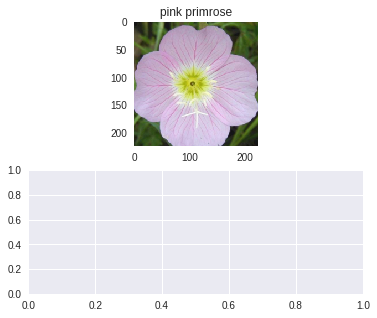

In [0]:
display_prediction(image, image_path, model, topk=5)

In [0]:
!git clone https://github.com/GabrielePicco/deep-learning-flower-identifier
!pip install requests
!pip install airtable
import sys
sys.path.insert(0, 'deep-learning-flower-identifier')
from test_model_pytorch_facebook_challenge import calc_accuracy

calc_accuracy(model, input_image_size=224)

fatal: destination path 'deep-learning-flower-identifier' already exists and is not an empty directory.


100.0% 35053568 / 35050314


Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.84375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.84375
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Mean accuracy: 0.9314903616905212


0.93149036